In [1]:
### imports

import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import roc_curve, auc
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from matplotlib import pyplot as plt
import seaborn as sns
import uproot
import awkward as ak
from scripts.models import MLP
from scripts.ksplot import make_ks_plot

In [2]:
# latex settings block

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.numpoints": 1,
    "axes.linewidth": 2,
    "legend.title_fontsize": 16,
    "axes.labelsize": 18,
    "legend.fontsize": 16
})

In [3]:
# load training and testing arrays along with their labels and variable and label names
# such a file is created at the end of the explore.ipynb notebook
with np.load('root_files/train_test_49variables.npz') as f:
    X_train = f['X_train']
    y_train = f['y_train']
    X_test = f['X_test']
    y_test = f['y_test']
    features = f['variables'].tolist()
    labels = f['labels'].tolist()

In [4]:
to_use = ['fj_eta',
          'fj_mass',
          'fj_phi',
          'fj_pt',
          'fj_ptDR']

num_of_variables = len(to_use)
indices = sorted([features.index(i) for i in to_use])
X_train_final = X_train[:,indices]
X_test_final = X_test[:,indices]

In [5]:
# build a simple neural network in keras with our imported MLP class
model = MLP(X_train_final.shape[1])
model.save_random_weights()
model.show_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 5)                20        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 60)                360       
                                                                 
 dense_1 (Dense)             (None, 60)                3660      
                                                                 
 dense_2 (Dense)             (None, 2)                 122       
                                                                 
Total params: 4,162
Trainable params: 4,152
Non-trainable params: 10
_________________________________________________________________
None


  0%|          | 0/20 [00:00<?, ?it/s]

2022-11-25 22:51:30.127760: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


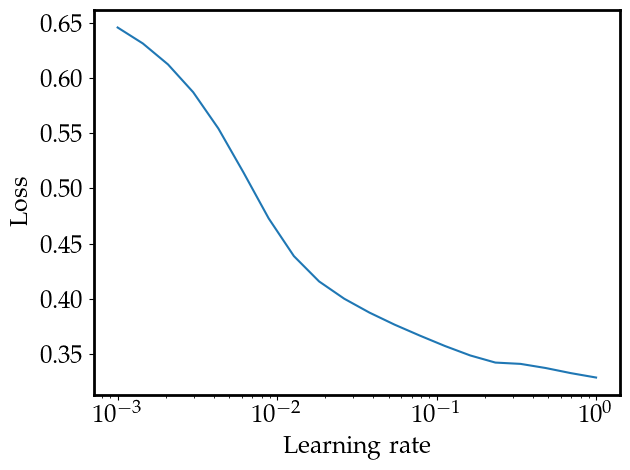

The optimal learning rate is 1.0


In [6]:
# train the model for 10 epochs for different values of learning rate and keep the value of the loss function
# for each learning rate at the end of the 10th epoch
# plot the loss vs the learning rate to find the optimal learning rate (lowest loss at epoch 10)
# keep the optimal learning rate and print it
model.find_optimal_lr(X_train_final, y_train, np.logspace(-3,0,20), verbosity = 0)

In [7]:
%%time
# fit keras model with using the calculated optimal learning rate and save the best weights in a file
model.train(X_train_final, y_train, X_test_final, y_test)

Epoch 1/100
55/55 [==============================] - 1s 17ms/step - loss: 0.4305 - accuracy: 0.7983 - val_loss: 0.3879 - val_accuracy: 0.8284
Epoch 2/100
55/55 [==============================] - 1s 15ms/step - loss: 0.3675 - accuracy: 0.8295 - val_loss: 0.3484 - val_accuracy: 0.8389
Epoch 3/100
55/55 [==============================] - 1s 15ms/step - loss: 0.3562 - accuracy: 0.8372 - val_loss: 0.3640 - val_accuracy: 0.8396
Epoch 4/100
55/55 [==============================] - 1s 14ms/step - loss: 0.3452 - accuracy: 0.8438 - val_loss: 0.3336 - val_accuracy: 0.8500
Epoch 5/100
55/55 [==============================] - 1s 15ms/step - loss: 0.3410 - accuracy: 0.8461 - val_loss: 0.3547 - val_accuracy: 0.8426
Epoch 6/100
55/55 [==============================] - 1s 15ms/step - loss: 0.3366 - accuracy: 0.8487 - val_loss: 0.3290 - val_accuracy: 0.8530
Epoch 7/100
55/55 [==============================] - 1s 14ms/step - loss: 0.3338 - accuracy: 0.8502 - val_loss: 0.3442 - val_accuracy: 0.8471
Epoch 

In [8]:
# print the loss and accuracy of the model on the train and test data sets
# run model inference on train and test data sets
evaluation_train, evaluation_test = model.evaluate(X_train_final, y_train, X_test_final, y_test)
predict_array_train, predict_array_test = model.predict(X_train_final, X_test_final)
accuracy = evaluation_test[1]

13921/13921 [==============================] - 5s 327us/step - loss: 0.3213 - accuracy: 0.8568
[0.3199881315231323, 0.8573842644691467]
[0.32125532627105713, 0.8568436503410339]
13921/13921 [==============================] - 4s 285us/step


In [9]:
# create ROC curve
fpr, tpr, threshold = roc_curve(y_test[:,0], predict_array_test[:,0])
np.savez(f'plots/ROC_MLP_{num_of_variables}variables', fpr = fpr, tpr = tpr)

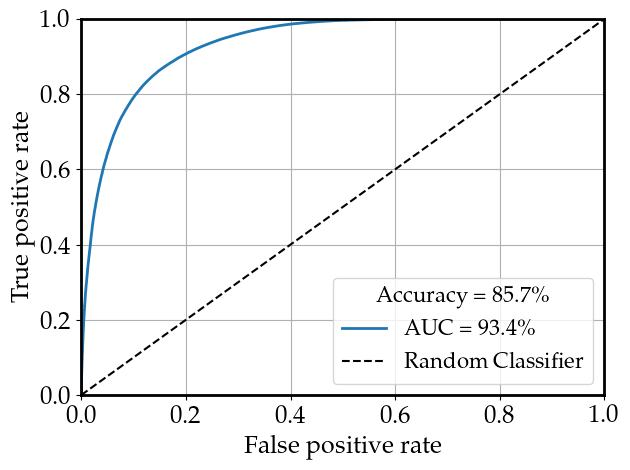

In [10]:
# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right', title=f'Accuracy = {accuracy*100:.1f}\%')
plt.tight_layout()
plt.savefig(f'plots/ROC_MLP_{num_of_variables}variables.pdf')
plt.show()

In [11]:
# create KS histogram of classifier output to check for overtraining
fig = make_ks_plot(y_train[:,0], predict_array_train[:,0],
                   y_test[:,0], predict_array_test[:,0])
fig.savefig(f'plots/KS_MLP_{num_of_variables}variables.pdf')

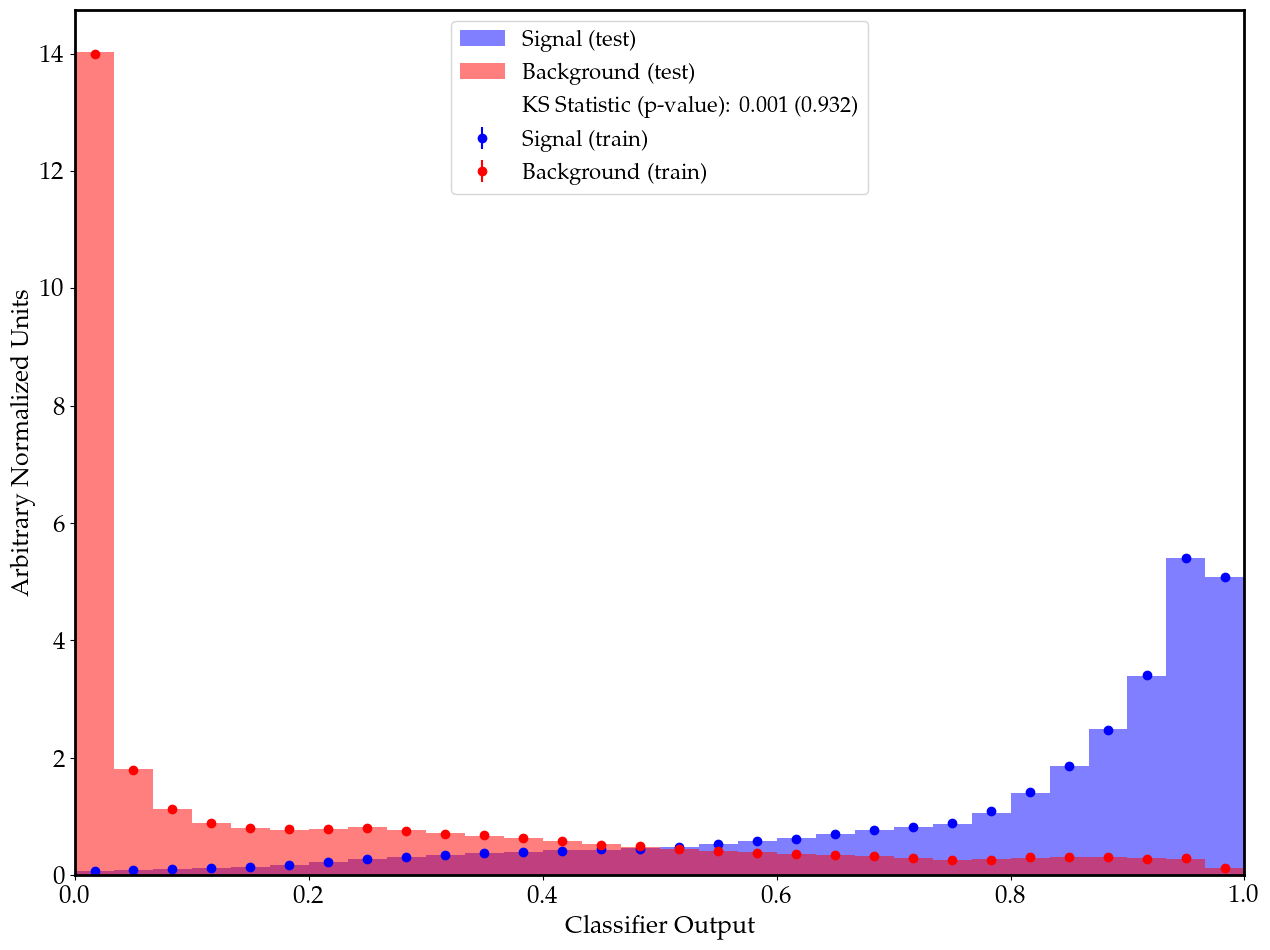

In [12]:
fig

In [13]:
# create a boosted decision tree classifier using the xgboost package
bdt = XGBClassifier(booster='gbtree')

In [14]:
%%time
# fit the BDT on training set
bdt.fit(X_train_final, y_train)

CPU times: user 11min 49s, sys: 2.94 s, total: 11min 52s
Wall time: 2min 21s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [15]:
# print the accuracies of the BDT on the training and testing data sets
print(bdt.score(X_train_final, y_train))
accuracy = bdt.score(X_test_final, y_test)
print(accuracy)

0.8606953900723142
0.8589650342115188


In [16]:
# run BDT inference on train and test data sets and create ROC curve
predict_array_train = bdt.predict_proba(X_train_final)
predict_array_test = bdt.predict_proba(X_test_final)
fpr, tpr, threshold = roc_curve(y_test[:,0], predict_array_test[:,0])
np.savez(f'plots/ROC_BDT_{num_of_variables}variables', fpr = fpr, tpr = tpr)

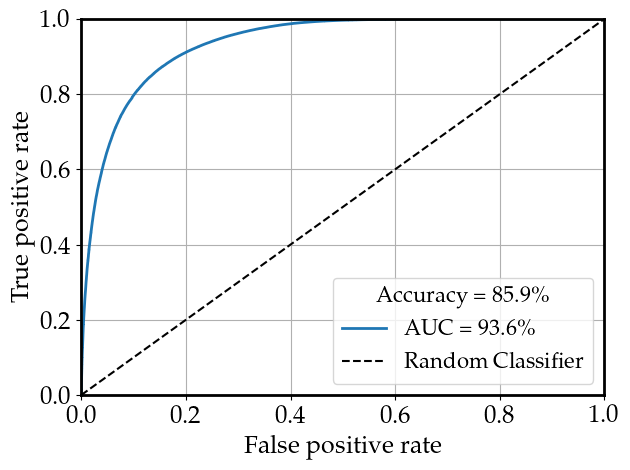

In [17]:
# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right', title=f'Accuracy = {accuracy*100:.1f}\%')
plt.tight_layout()
plt.savefig(f'plots/ROC_BDT_{num_of_variables}variables.pdf')
plt.show()

In [18]:
# create KS histogram of classifier output to check for overtraining
fig = make_ks_plot(y_train[:,0], predict_array_train[:,0],
                   y_test[:,0], predict_array_test[:,0])
fig.savefig(f'plots/KS_BDT_{num_of_variables}variables.pdf')

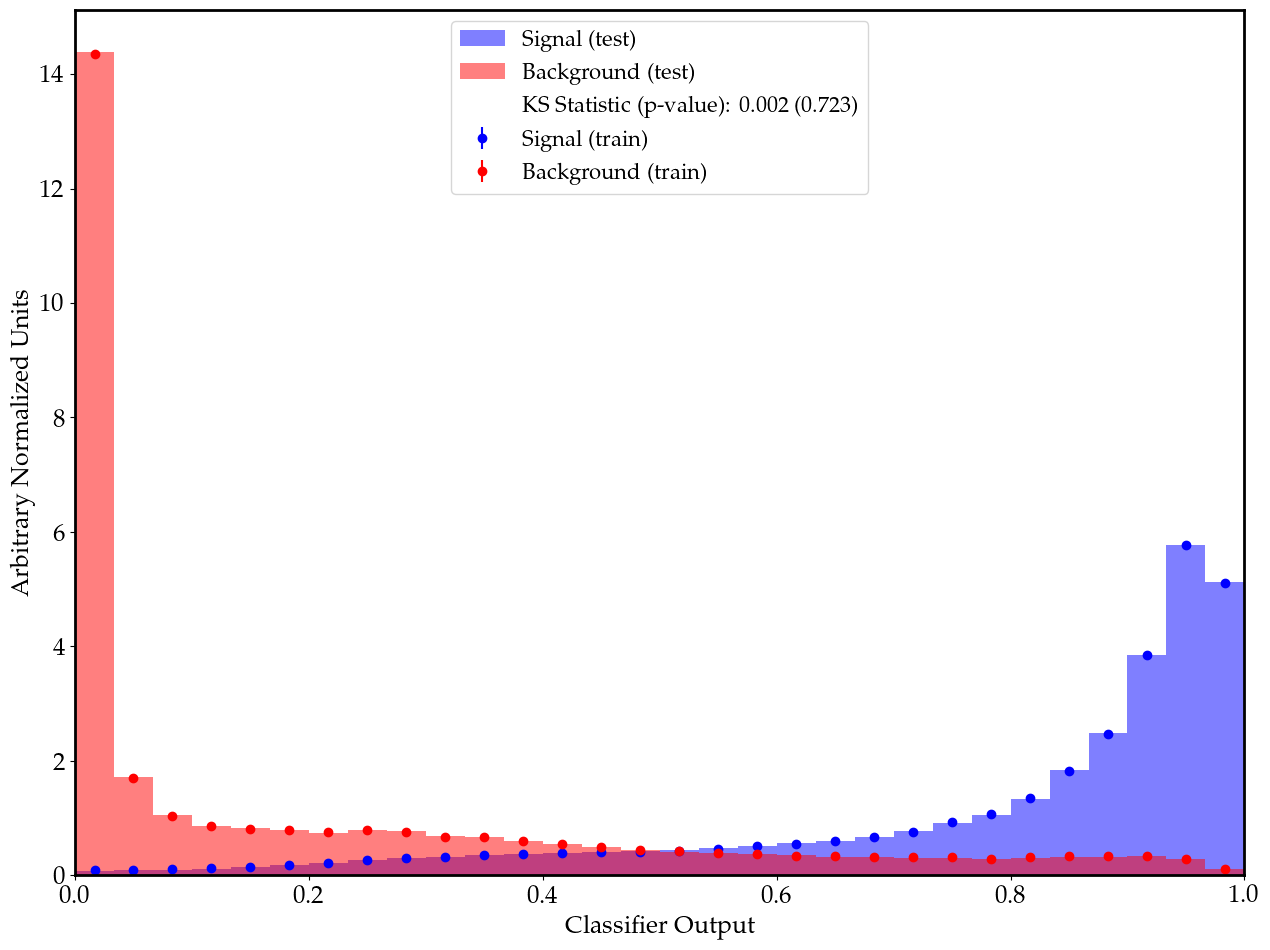

In [19]:
fig

In [20]:
# create Linear Discriminant Analysis classifier
fisher = LinearDiscriminantAnalysis()

In [21]:
%%time
# fit the LDA classifier on training set
fisher.fit(X_train_final, y_train[:,0])

CPU times: user 1.52 s, sys: 144 ms, total: 1.67 s
Wall time: 1.6 s


LinearDiscriminantAnalysis()

In [22]:
# print the accuracies of the LDA classifier on the training and testing data sets
print(fisher.score(X_train_final, y_train[:,0]))
accuracy = fisher.score(X_test_final, y_test[:,0])
print(accuracy)

0.7464783755573042
0.7460804913528366


In [23]:
# run LDA classifier inference on train and test data sets and create ROC curve
predict_array_train = fisher.predict_proba(X_train_final)
predict_array_test = fisher.predict_proba(X_test_final)
fpr, tpr, threshold = roc_curve(y_test[:,0], predict_array_test[:,1])
np.savez(f'plots/ROC_LDA_{num_of_variables}variables', fpr = fpr, tpr = tpr)

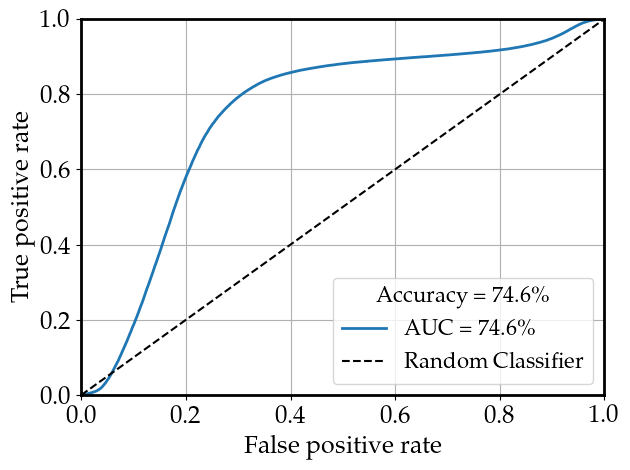

In [24]:
# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right', title=f'Accuracy = {accuracy*100:.1f}\%')
plt.tight_layout()
plt.savefig(f'plots/ROC_LDA_{num_of_variables}variables.pdf')
plt.show()

In [25]:
# create KS histogram of classifier output to check for overtraining
fig = make_ks_plot(y_train[:,0], predict_array_train[:,1],
                   y_test[:,0], predict_array_test[:,1])
fig.savefig(f'plots/KS_LDA_{num_of_variables}variables.pdf')

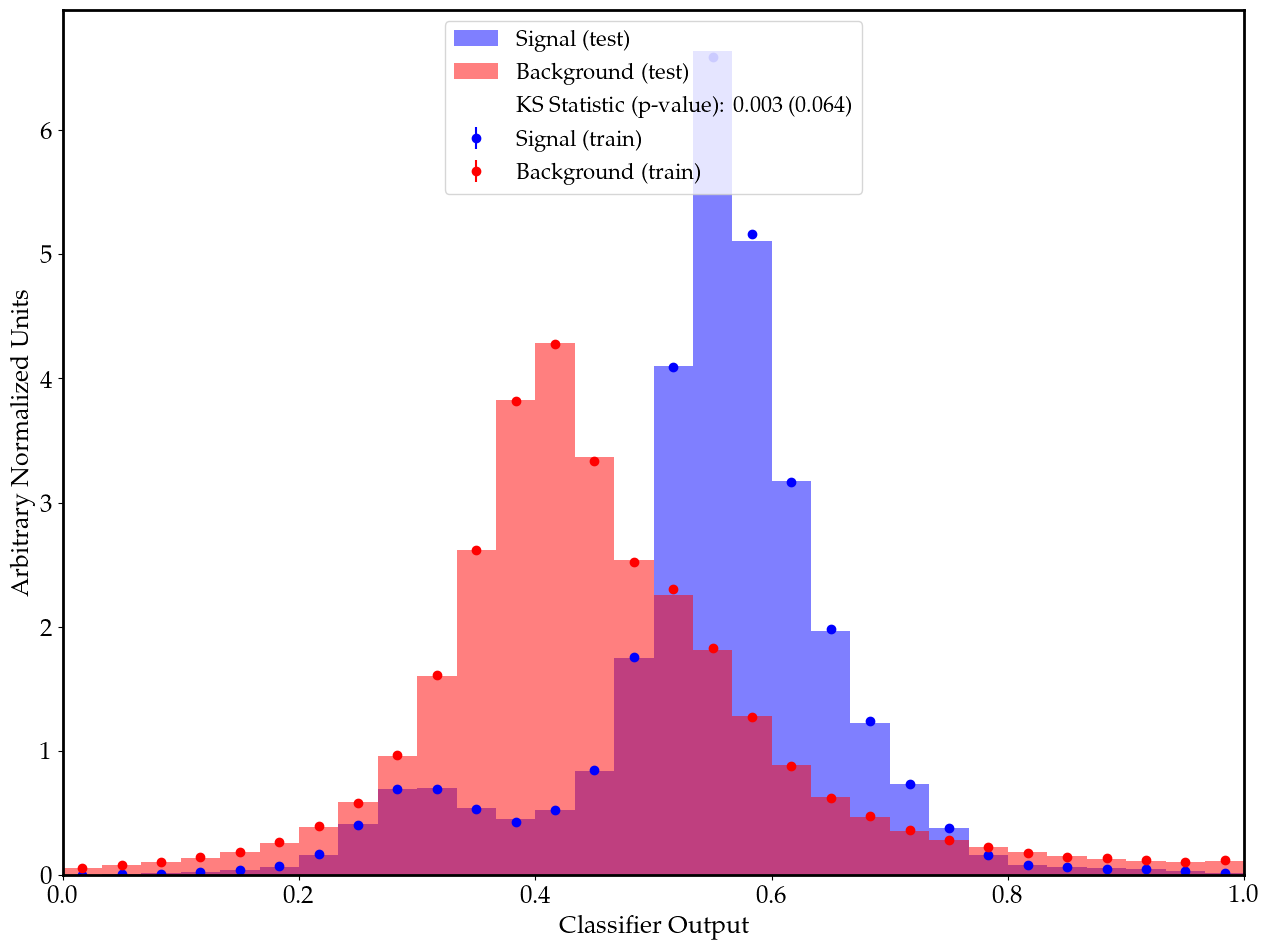

In [26]:
fig